# 1. Load Librares

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import warnings
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)  

In [2]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
from sklearn import model_selection
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [5]:
# display pd table side by side
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# 2. Prepare Data

### Read Data

In [6]:
# read training data 
train = pd.read_csv('data/train_FD001.txt', sep=" ", header=None)
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
train.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read test data
test = pd.read_csv('data/test_FD001.txt', sep=" ", header=None)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
test.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data# read  
truth = pd.read_csv('data/RUL_FD001.txt', sep=" ", header=None)
truth.drop(truth.columns[[1]], axis=1, inplace=True)

### Process Data

In [7]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train = train.merge(rul, on=['id'], how='left')
train['rul'] = train['max'] - train['cycle']
train.drop('max', axis=1, inplace=True)

# generate label columns for training data# gener 
w1 =15
train['w1'] = np.where(train['rul'] <= w1, 1, 0 )

# MinMax normalization
train['cycle_norm'] = train['cycle']
cols_normalize = train.columns.difference(['id','cycle','rul','w1','w2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train = pd.DataFrame(min_max_scaler.fit_transform(train[cols_normalize]), columns=cols_normalize, index=train.index)
train_join = train[train.columns.difference(cols_normalize)].join(norm_train)
train = train_join.reindex(columns = train.columns)

# add cycle_norm
test['cycle_norm'] = test['cycle']
norm_test = pd.DataFrame(min_max_scaler.transform(test[cols_normalize]), columns=cols_normalize, index=test.index)
test_join = test[test.columns.difference(cols_normalize)].join(norm_test)
test = test_join.reindex(columns = test.columns)
test = test.reset_index(drop=True)

# generate column max for test data
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth.columns = ['more']
truth['id'] = truth.index + 1
truth['max'] = rul['max'] + truth['more']
truth.drop('more', axis=1, inplace=True)

# generate RUL for test data
test = test.merge(truth, on=['id'], how='left')
test['rul'] = test['max'] - test['cycle']
test.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data# genera 
test['w1'] = np.where(test['rul'] <= w1, 1, 0 )

In [8]:
# prepare feature lists

feature = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
feature_s = ['cycle_norm','setting1','setting2','s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21']
feature_ts = ['cycle_norm','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

In [9]:
train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul,w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


In [12]:
test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,rul,w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


### Save Data

In [522]:
train.to_pickle('data/train.pkl')
test.to_pickle('data/test.pkl')

# 3. Regression

### Support Functions

In [532]:
# define regression metrics calculation

def get_regression_metrics(model_name, model, x_train, y_train, x_test, y_test):    
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    regression_metrics = {
        'Root mean squared error':      (mean_squared_error(y_test, y_pred))**0.5,
        'Mean absolute error':          mean_absolute_error(y_test, y_pred),
        'R2 score':                     r2_score(y_test, y_pred),
        'CV root mean squared error':   (-cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())**0.5,
        'CV mean absolute error':       -cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean(),
        'CV r2 score':                  cross_val_score(model, x_train, y_train, cv=5, scoring='r2').mean()
    }
    df_regression_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    df_regression_metrics.columns = [model_name]
    return df_regression_metrics

In [557]:
# define feature importance plot

def plot_feature_importance(model_name, model, x_train, y_train):
    model.fit(x_train, y_train)
    if model_name == 'DecisionTr' or model_name == 'RandomFore':
        W = pd.DataFrame({'weights': model.feature_importances_}, x_train.columns)
    else:
        W = pd.DataFrame({'weights': model.coef_}, x_train.columns)        
    W.sort_values(by='weights', ascending=True).plot(kind='barh', color='r', figsize=(10, 5))
    label = ' feature importance' if (model_name == 'DecisionTr' or model_name == 'RandomFore') else 'coefficients'
    plt.xlabel(model_name + label)
    plt.show()

In [527]:
# define Grid Search Based hyper-parameter adjustment

def best_model(model_name, model, x_train, y_train, x_test, params=None, score=None):
    grid_search = model_selection.GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    y_pred = grid_search.predict(x_test)
    if hasattr(grid_search, 'predict_proba'):
        y_score = grid_search.predict_prob(x_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(x_test)
    else:
        y_score = y_pred
    predictions = {'y_pred': y_pred, 'y_score': y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    return grid_search.best_estimator_, df_predictions, y_score

### Initial Model

In [528]:
lin_regr = linear_model.LinearRegression()                                         # linear regression
lasso_regr = linear_model.Lasso(alpha=0.1)                                         # LASSO regression
rd_regr = linear_model.Ridge(alpha=0.01)                                           # ridge regression
dtr_regr = DecisionTreeRegressor(max_depth=7, random_state=123)                    # decision tree regression
rf_regr = RandomForestRegressor(n_estimators = 50)                                 # random forest regression
list_reg_model_name = [(str(m).split('(')[0][0:10], m) for m in [lin_regr, lasso_regr, rd_regr, dtr_regr, rf_regr]]

### Feature Importance

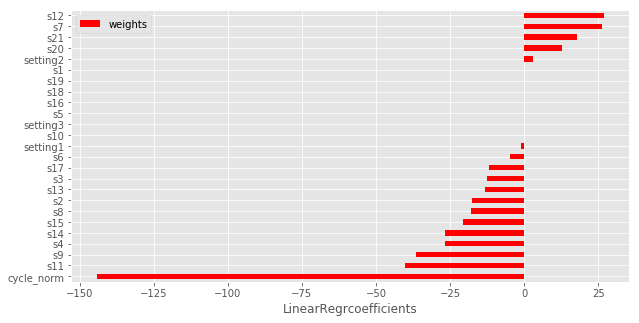

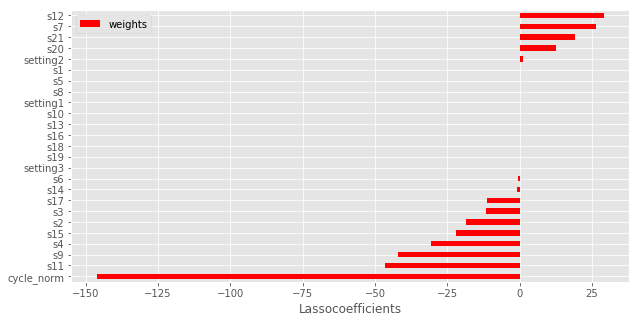

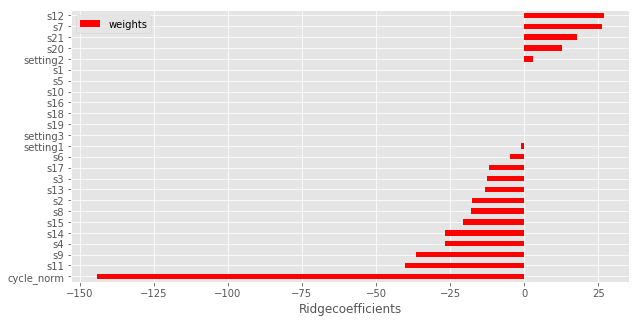

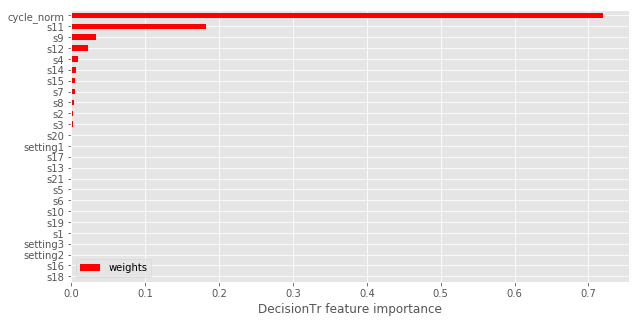

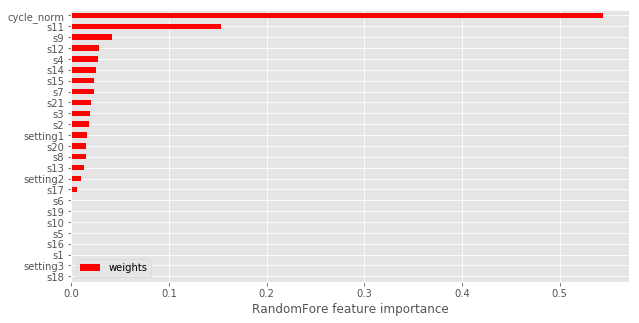

[None, None, None, None, None]

In [558]:
# Feature importance or coefficiency

[plot_feature_importance(name, model, train[feature_ts], train['rul']) for name, model in list_reg_model_name]

### Model Performance: Cycle + Setting + Full Sensors

In [533]:
newDF = pd.DataFrame()
for name, model in list_reg_model_name:
    newDF = pd.concat([newDF, get_regression_metrics(name, model, train[feature_ts], train['rul'], test[feature_ts], test['rul'])], axis=1)
newDF

,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
R2 score,0.470783,0.468797,0.470782,0.465182,0.501371
Mean absolute error,33.114456,33.143205,33.114476,32.589556,31.748913
CV r2 score,0.641115,0.641031,0.641116,0.671269,0.690417
Root mean squared error,42.904790,42.985243,42.904857,43.131264,41.646420
CV root mean squared error,41.930015,41.959424,41.929953,39.946912,38.838472
CV mean absolute error,32.259828,32.237078,32.259762,28.275521,27.314141


### Model Performance: Cycle + Setting + Less Sensors

In [534]:
newDF = pd.DataFrame()
for name, model in list_reg_model_name:
    newDF = pd.concat([newDF, get_regression_metrics(name, model, train[feature_s], train['rul'], test[feature_s], test['rul'])], axis=1)
newDF

,LinearRegr,Lasso,Ridge,DecisionTr,RandomFore
R2 score,0.471126,0.468808,0.471125,0.465600,0.499078
Mean absolute error,33.097615,33.142482,33.097635,32.582226,31.853812
CV r2 score,0.641238,0.641126,0.641239,0.671436,0.690326
Root mean squared error,42.890887,42.984801,42.890954,43.114372,41.742095
CV root mean squared error,41.920974,41.953132,41.920911,39.935378,38.879472
CV mean absolute error,32.264162,32.236049,32.264096,28.269125,27.320675


### Baseline = Random Forest
- Random Forest has better performance among basic ml models
- Less feature gain almost same performance, prefered

### Fine-Tune: Random Forest

In [561]:
# Grid Search Approach

model_name = 'random forest'
rf = RandomForestRegressor(random_state=1, min_samples_split=2)
rf_param = {'n_estimators': [200, 300, 400], 'max_depth': [6, 7, 8], 'min_samples_split': [2], 'min_samples_leaf': [2]}
rf_score = 'r2'
rf, Y_pred, Y_score = best_model(model_name, rf, train[feature_s], train['rul'], test[feature_s], params=rf_param, score=rf_score)
print('best parameters:\n', rf)

best parameters:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)


In [563]:
rf_fine = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)
rf_fine.fit(train[feature_s], train['rul'])
y_pred = rf_fine.predict(test[feature_s])
print('Root mean squared error:          ', (mean_squared_error(test['rul'], y_pred))**0.5)
print('Mean absolute error:              ', mean_absolute_error(test['rul'], y_pred))
print('R2 score:                         ', r2_score(test['rul'], y_pred))
print('CV root mean squared error:       ', (-cross_val_score(rf_fine, train[feature_s], train['rul'], cv=5, scoring='neg_mean_squared_error').mean())**0.5)
print('CV mean absolute error:           ', -cross_val_score(rf_fine, train[feature_s], train['rul'], cv=5, scoring='neg_mean_absolute_error').mean())
print('CV r2 score:                      ', cross_val_score(rf_fine, train[feature_s], train['rul'], cv=5, scoring='r2').mean())

Root mean squared error:           41.0008263848141
Mean absolute error:               30.934440946532984
R2 score:                          0.5167107139504211
CV root mean squared error:        38.07171222728815
CV mean absolute error:            26.797807902756716
CV r2 score:                       0.705378365773759


# 4. Binary Classification

### Support Functions

In [599]:
def get_class_metrics(model_name, model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    binclass_metrics = {
        'Accuracy' :      metrics.accuracy_score(y_test, y_pred),
        'Precision' :     metrics.precision_score(y_test, y_pred),
        'Recall' :        metrics.recall_score(y_test, y_pred),
        'F1 Score' :      metrics.f1_score(y_test, y_pred),
        'ROC AUC' :       metrics.roc_auc_score(y_test, y_pred),
        'CV accuracy':    cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy').mean(),
        'CV prevision':   cross_val_score(model, x_train, y_train, cv=5, scoring='precision').mean(),
        'CV recall':      cross_val_score(model, x_train, y_train, cv=5, scoring='recall').mean(),
        'CV f1 score':    cross_val_score(model, x_train, y_train, cv=5, scoring='f1').mean(),
        'CV roc auc':     cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc').mean()
                       }
    print(model_name, '-------------------------------------------','\nConfusion Matrix:')
    print(metrics.confusion_matrix(y_test, y_pred))
    print('Classification Report:')
    print(metrics.classification_report(y_test, y_pred))
        
    df_class_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_class_metrics.columns = [model_name]  
    return  df_class_metrics

### Initial Model

In [600]:
clf_lgrb  = LogisticRegression(random_state=123)                                   # Logistic Regression
clf_dtrb = DecisionTreeClassifier(random_state=123)                                # Decision Tree
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)               # Random Forest
clf_svcb = SVC(kernel='rbf', random_state=123)                                     # Support Vector Machine
clf_svlb = LinearSVC(random_state=123)                                             # Linear SVC
clf_knnb = KNeighborsClassifier(n_jobs=-1)                                         # K Nearest Neighbor
clf_gnbb = GaussianNB()                                                            # Gaussian Naive Bayes
list_class_model_name = [(str(m).split('(')[0][0:10], m) for m in [clf_lgrb, clf_dtrb, clf_rfcb, clf_svcb, clf_svlb, clf_knnb, clf_gnbb]]

### Model Performance

In [601]:
clfDF = pd.DataFrame()
for name, model in list_class_model_name:
    clfDF = pd.concat([clfDF, get_class_metrics(name, model, train[feature_s], train['w1'], test[feature_s], test['w1'])], axis=1)
clfDF

LogisticRe ------------------------------------------- 
Confusion Matrix:
[[13016    20]
 [   21    39]]
Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13036
          1       0.66      0.65      0.66        60

avg / total       1.00      1.00      1.00     13096

DecisionTr ------------------------------------------- 
Confusion Matrix:
[[12993    43]
 [   23    37]]
Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13036
          1       0.46      0.62      0.53        60

avg / total       1.00      0.99      1.00     13096

RandomFore ------------------------------------------- 
Confusion Matrix:
[[13024    12]
 [   26    34]]
Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     13036
          1       0.74      0.57      0.64        60

avg / total       1.00   

,LogisticRe,DecisionTr,RandomFore,SVC,LinearSVC,KNeighbors,GaussianNB
CV roc auc,0.994628,0.883629,0.991099,0.994586,0.995003,0.975120,0.994154
ROC AUC,0.824233,0.806684,0.782873,0.807911,0.841053,0.757681,0.991907
Precision,0.661017,0.462500,0.739130,0.770833,0.719298,0.645833,0.221402
Recall,0.650000,0.616667,0.566667,0.616667,0.683333,0.516667,1.000000
CV prevision,0.869052,0.759199,0.858990,0.870480,0.870186,0.836824,0.518782
F1 Score,0.655462,0.528571,0.641509,0.685185,0.700855,0.574074,0.362538
Accuracy,0.996869,0.994960,0.997098,0.997404,0.997327,0.996487,0.983888
CV f1 score,0.853279,0.772337,0.845804,0.851465,0.856944,0.831171,0.681759
CV accuracy,0.977606,0.963792,0.976395,0.977412,0.978091,0.973777,0.927100
CV recall,0.839375,0.788750,0.835000,0.834375,0.845625,0.828125,0.998125


### Baseline = LinearSVC
- Performance balanced in all areas